In [59]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import math 

%matplotlib inline

In [26]:
df = pd.read_csv('../df.csv')

In [27]:
df.head()

,season,title,rating,votes,double,episode,votes_norm,month,writer_B.J._Novak,writer_Mindy_Kaling,...,whispering,screaming,singing,applause,accent,crying,smiling,sigh,kiss,one
0,1,Pilot,7.4,7006,0,1,0.009148,3,0,0,...,0,1,1,0,0,1,0,1,0,1
1,1,Diversity Day,8.3,6902,0,2,0.009012,3,1,0,...,0,0,0,0,3,1,0,0,0,1
2,1,Health Care,7.7,5756,0,3,0.007516,4,0,0,...,0,0,0,1,0,0,0,0,0,1
3,1,The Alliance,8.0,5579,0,4,0.007285,4,0,0,...,2,1,1,0,0,0,0,0,1,1
4,1,Basketball,8.4,6183,0,5,0.008073,4,0,0,...,0,0,3,2,0,0,0,0,0,1


In [57]:
def RMSE(y, y_pred):
    SME = sum((y - y_pred)**2)
    
    return round(math.sqrt(SME/len(y)),3)

## Delete features are not used in model

In [28]:
columns = df.columns

characters_words_total = [word for word in columns if '_words_total' in word]

In [32]:
to_drop = ['title','season','episode'] + characters_words_total

In [33]:
df_model = df.drop(columns=to_drop, axis=1)

## train-test splittin

In [34]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df_model, test_size=0.30, shuffle=True, random_state=1)

<AxesSubplot:ylabel='rating'>

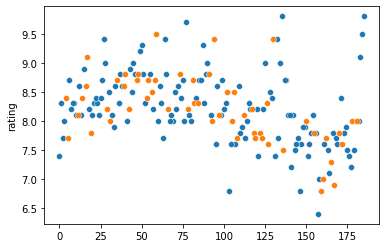

In [35]:
sns.scatterplot(x=train.index,y=train.rating)
sns.scatterplot(x=test.index,y=test.rating)

## Choosing most important properties using random forest

In [37]:
from sklearn.ensemble import RandomForestRegressor

### tune hyperparameter with RandomizedSearchCV

In [38]:
from sklearn.model_selection import RandomizedSearchCV

In [42]:
from pprint import pprint

In [43]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


In [45]:
dtree = RandomForestRegressor()

In [51]:
rf_random = RandomizedSearchCV(estimator = dtree, 
                               param_distributions = random_grid, 
                               n_iter = 50, 
                               cv = 5, verbose=2, 
                               random_state=42, 
                               n_jobs = -1)

In [52]:
rf_random.fit(train.drop(columns=['rating', 'votes','votes_norm'], axis=1), train.rating)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  6.7min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:  8.9min finished


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_iter=50,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [53]:
rf_random.best_params_

{'n_estimators': 800,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 100,
 'bootstrap': True}

In [60]:
prediction = rf_random.best_estimator_.predict(test.drop(columns=['rating', 'votes','votes_norm'], axis=1))
RMSE(test.rating.values, prediction)

0.487

In [78]:
mean_y = test.rating.values.mean()

1 - sum((test.rating.values-prediction)**2)/sum((test.rating.values-mean_y)**2)

0.27199118020800206

[Text(0.5, 1.0, 'residuals across episodes')]

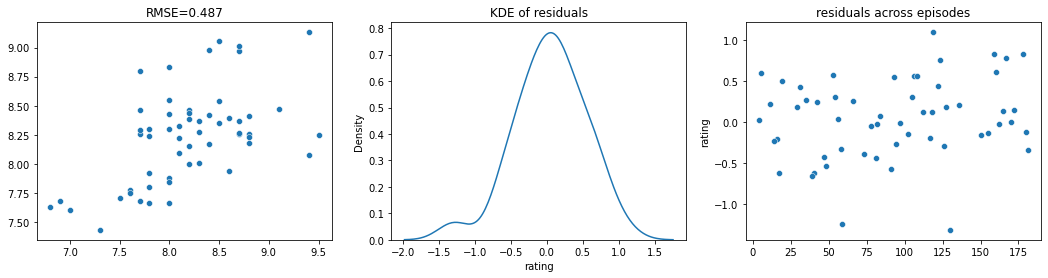

In [79]:
fig,ax = plt.subplots(figsize=(18,4), nrows=1, ncols=3)
    
sns.scatterplot(x=test.rating.values, y=prediction, ax=ax[0]).set(title=f'RMSE={RMSE(test.rating.values, prediction)}')
sns.kdeplot(prediction-test.rating,ax=ax[1]).set(title='KDE of residuals')
sns.scatterplot(x=test.index, y=prediction-test.rating,ax=ax[2]).set(title='residuals across episodes')

<AxesSubplot:xlabel='Importance', ylabel='Variable'>

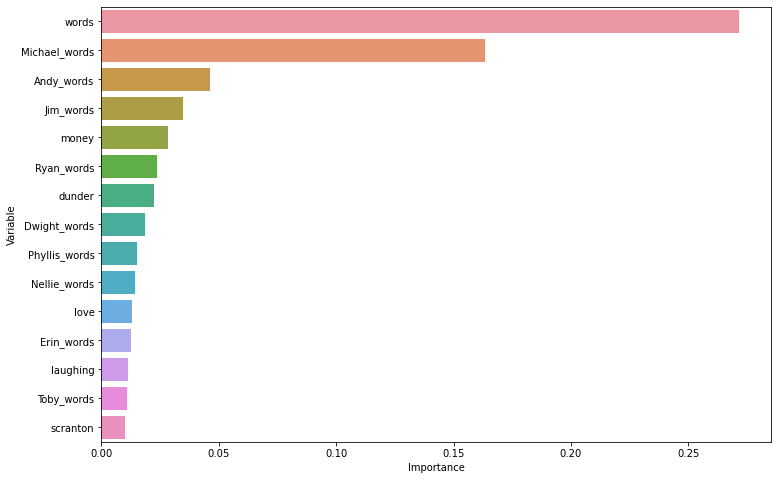

In [62]:
importance = pd.DataFrame({'Variable':train.drop(columns=['rating', 'votes','votes_norm'], axis=1).columns,
              'Importance':rf_random.best_estimator_.feature_importances_}).sort_values('Importance', ascending=False)

plt.figure(figsize=(12,8))
sns.barplot(x=importance[importance.Importance > 0.01].Importance, y=importance[importance.Importance > 0.01].Variable)

### GridSearchCV

In [80]:
from sklearn.model_selection import GridSearchCV

In [81]:
param_grid = {
    'bootstrap': [True],
    'max_depth': [100, 110, 120, 130],
    'max_features': [30,60,90,120],
    'min_samples_leaf': [1, 2, 3],
    'min_samples_split': [1, 2, 3, 4],
    'n_estimators': [600,800, 1000,1200]
}

In [83]:
grid_search = GridSearchCV(estimator = dtree, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [84]:
grid_search.fit(train.drop(columns=['rating', 'votes','votes_norm'], axis=1), train.rating)

Fitting 3 folds for each of 768 candidates, totalling 2304 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   39.6s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed: 12.2min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed: 19.2min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed: 27.5min
[Parallel(n_jobs=-1)]: Done 1977 tasks      | elapsed: 37.7min
[Parallel(n_jobs=-1)]: Done 2304 out of 2304 | elapsed: 44.4min finished


GridSearchCV(cv=3, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'bootstrap': [True], 'max_depth': [100, 110, 120, 130],
                         'max_features': [30, 60, 90, 120],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [1, 2, 3, 4],
                         'n_estimators': [600, 800, 1000, 1200]},
             verbose=2)

In [85]:
grid_search.best_params_

{'bootstrap': True,
 'max_depth': 120,
 'max_features': 120,
 'min_samples_leaf': 1,
 'min_samples_split': 3,
 'n_estimators': 600}

In [86]:
prediction = grid_search.best_estimator_.predict(test.drop(columns=['rating', 'votes','votes_norm'], axis=1))
RMSE(test.rating.values, prediction)

0.463

In [87]:
mean_y = test.rating.values.mean()

1 - sum((test.rating.values-prediction)**2)/sum((test.rating.values-mean_y)**2)

0.3435068413960415

[Text(0.5, 1.0, 'residuals across episodes')]

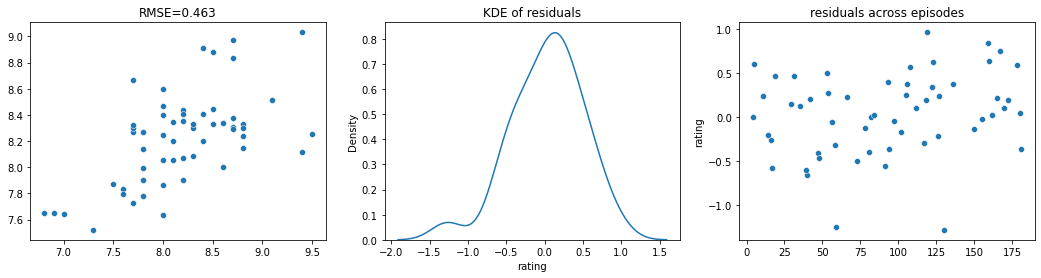

In [88]:
fig,ax = plt.subplots(figsize=(18,4), nrows=1, ncols=3)
    
sns.scatterplot(x=test.rating.values, y=prediction, ax=ax[0]).set(title=f'RMSE={RMSE(test.rating.values, prediction)}')
sns.kdeplot(prediction-test.rating,ax=ax[1]).set(title='KDE of residuals')
sns.scatterplot(x=test.index, y=prediction-test.rating,ax=ax[2]).set(title='residuals across episodes')

<AxesSubplot:xlabel='Importance', ylabel='Variable'>

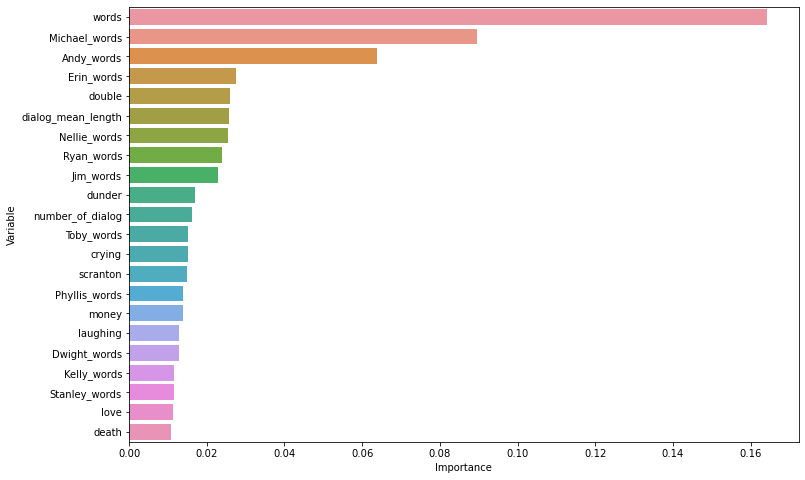

In [89]:
importance = pd.DataFrame({'Variable':train.drop(columns=['rating', 'votes','votes_norm'], axis=1).columns,
              'Importance':grid_search.best_estimator_.feature_importances_}).sort_values('Importance', ascending=False)

plt.figure(figsize=(12,8))
sns.barplot(x=importance[importance.Importance > 0.01].Importance, y=importance[importance.Importance > 0.01].Variable)